#### Goal

Using Machine Learning algorithms to accurately predict the location of Uranium deposits using
surface level-data, such as magnetic and radiometric values


#### Project Description

Our main dataset for training/testing is from the United States Geological Survey and was gathered in 1976. In this survey, data was gathered by aircraft that flew over the border area of New Mexico and Texas, and recorded magnetic-field and radiometric values and locations. Contained in this dataset are latitude, longitude, altitude, and magnetic-field values. Additionally, there are geologic symbols detailing the area in the data sets. The aircrafts tracked the locations of Uranium, Thorium, and Potassium, but we will be focusing on Uranium in this project. We plan to group the different elements using Agglomerative Hierarchical Clustering. 

This section of imports displays the various packages used in our project

In [47]:
import pandas as pd # used for DataFrames
import numpy as np # used for numpy arrays
import matplotlib.pyplot as plt # used to graphically visualize data points
from sklearn.cluster import AgglomerativeClustering, KMeans # for machine learning algorithms
import scipy.cluster.hierarchy as sch # for dendrograms
from sklearn.preprocessing import MinMaxScaler

Function to organize .xyz file data into python list with correct data types of features.
Lists will be used as input data in Pandas DataFrame

In [48]:
def xyz_to_list(xyz_file):
    data_list = []
    for row in xyz_file:
        # splits rows of .xyz data to list of strings
        row_array = row.split()
        # changes string values in list to correct data type
        for i in range(len(row_array)):
            if row_array[i].find(".") != -1:
                row_array[i] = float(row_array[i])
            elif row_array[i].isdigit() or row_array[i][1:].isdigit():
                row_array[i] = int(row_array[i])
        # adds list of row data to the main list
        data_list.append(row_array)
    # returns organized list of data
    return data_list

In [49]:
# Magnetic .xyz file to python list
clovis_mag = "CLOVIS/clovis_mag.xyz" # magnetic data file path
xyz_mag = open(clovis_mag, "r") # create xyz file object
mag_list = xyz_to_list(xyz_mag) # magnetic data formatted in python list

print(mag_list[0])

[16, 211, 115600, 103, 1976, 34.696, -101.9878, 139.9, 53303.7, -176.9, -9999.9, 'TO', 107.0]


Cell creates DataFrame for the magnetic data and removes the features that we decided were unnecessary

In [50]:
# DataFrame for magnetic data
mag_DataFrame = pd.DataFrame(mag_list, columns=["line", "fid", "time", "day", "year", "latitude", 
                                    "longitude", "radalt", "totmag", "resmag", "diurnal", "geology", "resmagCM4"])

# Option forces all columns of data to be printed in the DataFrame
pd.set_option('display.max_columns', None)

# uses drop() function to remove line, time, day, and year features from the magnetic dataset
mag_DataFrame = mag_DataFrame.drop(columns=["line", "time", "day", "year"])

In [51]:
# First 10 rows of mag data
mag_DataFrame.head(10)

,fid,latitude,longitude,radalt,totmag,resmag,diurnal,geology,resmagCM4
0,211,34.6960,-101.9878,139.9,53303.7,-176.9,-9999.9,TO,107.0
1,212,34.6960,-101.9878,139.9,53303.7,-176.9,-9999.9,TO,107.0
2,213,34.6968,-101.9883,137.8,53304.4,-176.8,-9999.9,TO,107.2
3,214,34.6974,-101.9888,136.2,53306.5,-175.0,-9999.9,TO,109.0
4,215,34.6981,-101.9893,135.3,53304.8,-177.1,-9999.9,TO,106.8
5,216,34.6987,-101.9898,135.0,53305.2,-177.0,-9999.9,TO,107.0
6,217,34.6992,-101.9903,134.4,53306.6,-175.9,-9999.9,TO,108.1
7,218,34.6997,-101.9908,136.9,53304.8,-177.8,-9999.9,TO,106.2
8,219,34.7004,-101.9913,138.7,53306.7,-176.2,-9999.9,TO,107.7
9,220,34.7012,-101.9918,138.7,53306.1,-177.3,-9999.9,TO,106.8


#### Magnetic DataFrame Labels (70228 rows × 9 columns)


    0: fiducial number (integer)
    1: latitude (decimal degrees)
    2: longitude (decimal degrees)
    3: radar altimeter reading above ground (meters)
    4: corrected magnetic value (nT)
    5: residual magnetic value (nT)
    6: ground magnetometer value (nT)
    7: surficial geology beneath flight line (coded)
    8: resmag calculated using the comprehensive model (nT)

In [52]:
# Radiometric xyz file to python lists
clovis_rad = "CLOVIS/clovis_rad.xyz" # radiometric data file path
xyz_rad = open(clovis_rad, "r") # create xyz file object
rad_list = xyz_to_list(xyz_rad) # radiometric data formatted in python list

print(rad_list[0])

[1, 1, 171900, 102, 1976, 34.0081, -104.0169, 141.1, -266.0, -99, -9999, 140.0, 9.0, 27.0, -999.9, -999.9, -999.9, 3614.0, 601.0, 20.8, 651.3]


Cell creates DataFrame for the radiometric data and removes the features that we decided were unnecessary

In [53]:
# DataFrame for radiometric data
rad_DataFrame = pd.DataFrame(rad_list, columns = ["line", "fid", "time", "day", "year", "latitude", "longitude", "radalt", "resmag", "geology", "qual", 
                            "app_K", "app_U", "app_Th", "U_Th_ratio", "U_K_ratio", "Th_K_ratio", "total_count", "atmos_BI214", "air_temp", "air_press"])


# uses drop() function to remove line, time, day, and year features from the radiometric dataset
rad_DataFrame = rad_DataFrame.drop(columns=["line", "time", "day", "year"])

In [54]:
rad_DataFrame.head(10)

,fid,latitude,longitude,radalt,resmag,geology,qual,app_K,app_U,app_Th,U_Th_ratio,U_K_ratio,Th_K_ratio,total_count,atmos_BI214,air_temp,air_press
0,1,34.0081,-104.0169,141.1,-266.0,-99,-9999,140.0,9.0,27.0,-999.9,-999.9,-999.9,3614.0,601.0,20.8,651.3
1,2,34.0081,-104.0169,141.1,-266.0,-99,-9999,140.0,9.0,27.0,-999.9,-999.9,-999.9,3614.0,601.0,20.8,651.3
2,3,34.0081,-104.0169,141.1,-266.0,-99,-9999,140.0,9.0,27.0,-999.9,-999.9,-999.9,3614.0,601.0,20.8,651.3
3,4,34.0084,-104.0164,136.6,-266.0,-99,-9999,157.0,29.0,10.0,-999.9,-999.9,-999.9,3660.0,597.0,20.8,654.1
4,5,34.0088,-104.0158,132.6,-266.0,-99,-9999,97.0,54.0,30.0,-999.9,-999.9,-999.9,3584.0,593.0,20.5,651.3
5,6,34.0090,-104.0153,129.2,-266.0,-99,-9999,112.0,66.0,36.0,-999.9,-999.9,-999.9,3657.0,589.0,20.8,656.3
6,7,34.0096,-104.0147,126.8,-265.0,-99,-9999,153.0,3.0,31.0,-999.9,-999.9,-999.9,3618.0,587.0,20.2,654.1
7,8,34.0100,-104.0142,124.1,-266.0,-99,-9999,115.0,71.0,26.0,-999.9,-999.9,-999.9,3535.0,584.0,20.8,648.7
8,9,34.0102,-104.0136,123.4,-264.0,-99,-9999,135.0,82.0,16.0,-999.9,-999.9,-999.9,3594.0,583.0,20.5,650.0
9,10,34.0104,-104.0131,122.5,-265.0,-99,-9999,160.0,66.0,10.0,-999.9,-999.9,-999.9,3683.0,582.0,20.8,651.3


#### Radiometric DataFrame Labels (70651 rows × 17 columns)

    0: fiducial number (integer)
    1: latitude (decimal degrees)
    2: longitude (decimal degrees)
    3: radar altimeter reading above ground (meters)
    4: residual magnetic value (nT)
    5: surficial geology beneath flight line (coded)
    6: quality flags of the radiometrics (integer)
    7: apparent Potassium as Potassium 40 (percent potassium)
    8: apparent Uranium as Bismuth 214 (parts per million equivalent uranium)
    9: apparent Thorium as Thallium 208 (parts per million equivalent thorium)
    10: ratio of Uranium and Thorium
    11: ratio of Uranium and Potassium
    12: ratio of Thorium and Potassium
    13: total count of radioactivity (counts/second)
    14: atmospheric Uranium as Bi214 (counts/second)
    15: air temperature (degrees Celsius)
    16: air pressure (mmHg)

Cell creates a scatter plot to visualize the total counts of radioactivity (measured in counts/second) gathered during each individual reading

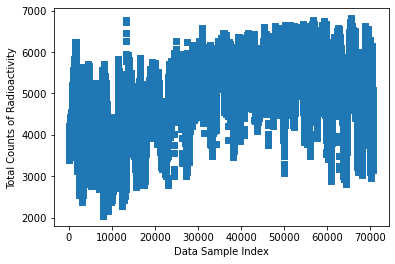

In [55]:
rad_count_column = rad_DataFrame.loc[:, "total_count"]
# radioactivity count numpy array
rad_count = rad_count_column.values

# plots counts of radioactivty detected in counts/second
plt.scatter(x=range(len(rad_count)), y=rad_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Total Counts of Radioactivity") # y-axis label
plt.show()


Cell creates a scatter plot to visualize the apparent percentages of Potassium 40 recorded during each reading

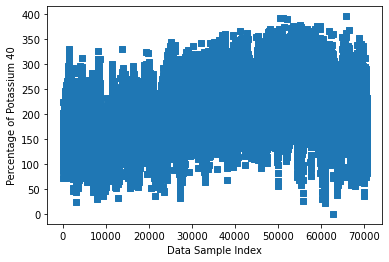

In [56]:
K_count_column = rad_DataFrame.loc[:, "app_K"]
# percentages of potassium numpy array
K_count = K_count_column.values

# plots apparent percentages of Potassium 40 at each reading
plt.scatter(x=range(len(K_count)), y=K_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Percentage of Potassium 40") # y-axis label
plt.show()

Percentages exceed 100 for some reason?

Cell creates a scatter plot to visualize the apparent amount of Uranium (measured in parts/million) seen during each reading. The readings actually record the radioactive isotope Bismuth 214 instead of Uranium directly, because this isotope is used to estimate the concentrations of Uranium. 

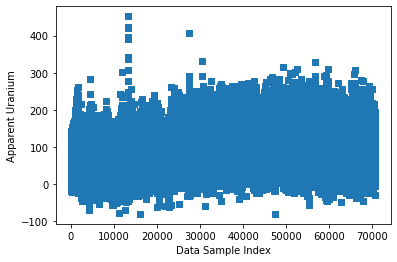

In [57]:
U_count_column = rad_DataFrame.loc[:, "app_U"]
# Bismuth 214 count numpy array
U_count = U_count_column.values

# plots apparent concentrations of Uranium as Bismuth 214
plt.scatter(x=range(len(U_count)), y=U_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Apparent Uranium") # y-axis label
plt.show()

Cell creates a scatter plot to visualize the apparent amount of Thorium (measured in parts/million) seen during each reading. In this data, the element Thorium is measured by estimating its concentation using the isotope Thallium 208.

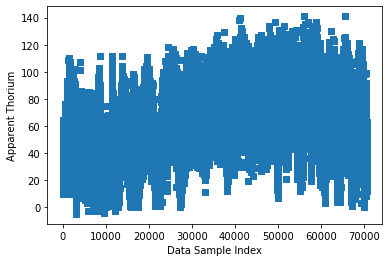

In [58]:
Th_count_column = rad_DataFrame.loc[:, "app_Th"]
# Thallium 208 count numpy array
Th_count = Th_count_column.values

# plots apparent concentrations of Thorium as Thallium 208
plt.scatter(x=range(len(Th_count)), y=Th_count, marker=",")
plt.xlabel("Data Sample Index") # x-axis label
plt.ylabel("Apparent Thorium") # y-axis label
plt.show()

#### Clustering

New DataFrame holds the feature data that will be used for clustering

Adapted code from "https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019"

In [59]:
# Organizes data with chosen features for clustering
resmag_data_column = mag_DataFrame.loc[:, ["resmag"]]
rad_count_column = rad_DataFrame.loc[range(len(resmag_data_column)), "total_count"]

clustering_DataFrame = pd.concat([resmag_data_column, rad_count_column], axis=1)


In [60]:
clustering_DataFrame.head(10)

,resmag,total_count
0,-176.9,3614.0
1,-176.9,3614.0
2,-176.8,3614.0
3,-175.0,3660.0
4,-177.1,3584.0
5,-177.0,3657.0
6,-175.9,3618.0
7,-177.8,3535.0
8,-176.2,3594.0
9,-177.3,3683.0


In [61]:
# Function used to normalize input data to values between 0 and 1
def normalize(input_data):
    scaler = MinMaxScaler()
    scaler.fit(input_data)
    return scaler.transform(input_data)

In [70]:
# turns DataFrame into an array of raw numerical values
# full dataset takes too long to cluster so only used first 40,000 index values
cluster_data_array = clustering_DataFrame.head(40000).values

# normalizes data
cluster_data_array = normalize(cluster_data_array)
print(cluster_data_array)

[[0.76324426 0.33290951]
 [0.76324426 0.33290951]
 [0.76330286 0.33290951]
 ...
 [0.73640413 0.8427633 ]
 [0.73347398 0.80546726]
 [0.73165729 0.82983683]]


In [71]:
# initializes model and fits model with radiometric and magnetic data

# chose 3 clusters, as there are 3 different elements detected in the dataset (Potassium, Uranium, and Thorium)
clustering_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clustering_model.fit(cluster_data_array)

AgglomerativeClustering(n_clusters=3)

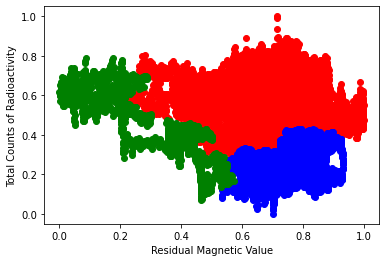

In [64]:
# array stores labels of the data that were assigned by the clustering algorithm
cluster_labels = clustering_model.labels_

# visualization of cluster using scatter plot
plt.scatter(cluster_data_array[cluster_labels==0, 0], cluster_data_array[cluster_labels==0, 1], marker='o', color='red')
plt.scatter(cluster_data_array[cluster_labels==1, 0], cluster_data_array[cluster_labels==1, 1], marker='o', color='blue')
plt.scatter(cluster_data_array[cluster_labels==2, 0], cluster_data_array[cluster_labels==2, 1], marker='o', color='green')
plt.xlabel("Residual Magnetic Value")
plt.ylabel("Total Counts of Radioactivity")
plt.show()

#### K Means Clustering
Adapted code from: https://github.com/codebasics/py/blob/master/ML/13_kmeans/13_kmeans_tutorial.ipynb

In [65]:
df = pd.DataFrame(clustering_DataFrame, columns = ['resmag', 'total_count']) #redefine the dataframe

def elbow_graph():
    sse = [] #elbow graph to find the ideal k value
    k_rng = range(1,10)
    for k in k_rng:
        km = KMeans(n_clusters=k)
        km.fit(df[['resmag','total_count']])
        sse.append(km.inertia_)
    plt.xlabel('K')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng, sse)
    plt.show()


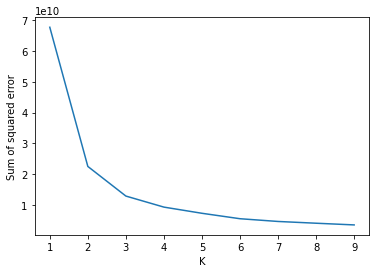

In [66]:
# Displays Graph
elbow_graph()

Data Normalization

In [67]:
def scale(): # scale the data from zero to one
    scaler = MinMaxScaler()
    scaler.fit(df[['total_count']])
    df['total_count'] = scaler.transform(df[['total_count']])

    scaler.fit(df[['resmag']])
    df['resmag'] = scaler.transform(df[['resmag']])

KMeans Algorithm and Visualization of Results

In [68]:
def kmeans():
    km = KMeans(n_clusters=3) #three clusters via elbow graph
    pred_y = km.fit_predict(df) #assigns a cluster to each row of the dataset
    print((pred_y))
    df['cluster'] = pred_y  #appends the cluster predictions to the dataset
    # print(df)

    #visualize the clusters
    km1 = df[pred_y==0]
    km2 = df[pred_y==1]
    km3 = df[pred_y==2]
    plt.scatter(km1.resmag,km1['total_count'], color='red')
    plt.scatter(km2.resmag,km2['total_count'], color='blue')
    plt.scatter(km3.resmag,km3['total_count'], color='green')
    plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='white',marker='*',label='centroid') #mark centroids
    plt.xlabel("Residual Magnetic Value")
    plt.ylabel("Total Counts of Radioactivity")
    plt.show()

[2 2 2 ... 2 2 2]


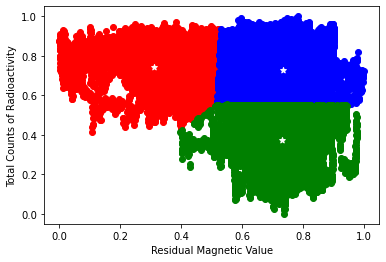

In [69]:
scale()
kmeans()